In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
# f(x) = a(b(c(d(x))))
# function = [d, c, b, a]
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical, plot_model
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
_ = tf.compat.v1.Session(config=config)


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [4]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


### Load the encoded protein sequences, labels and masks

In [5]:
# The masks are not needed for the FFN or CNN models
train = np.load('/gdrive/My Drive/ProteinsML/Protein-subcellular-localization/data/reduced_train.npz')
X_train = train['X_train']
y_train = train['y_train']
mask_train = train['mask_train']
#print(X_train.shape)
#print(X_train)

validation = np.load('/gdrive/My Drive/ProteinsML/Protein-subcellular-localization/data/reduced_val.npz')
X_val = validation['X_val']
y_val = validation['y_val']
mask_val = validation['mask_val']
#print(X_val.shape)

### Building the network by defining the network architecture.
We have an input layer, dense layer and output layer.

In [6]:
# Set the hyperparameters of the network:
batch_size = 128
seq_len = 400
n_feat = 20
n_hid = 30
n_class = 10
lr = 0.0025
drop_prob = 0.5

# Dummy data to check the size of the layers during the building of the network
X = np.random.randint(0, 10, size=(batch_size, seq_len, n_feat))
# print("x: {}".format(X))

Define the layers of the network

In [7]:
input_shape = (seq_len, n_feat)
model = Sequential()
# Input layer, holds the shape of the data, flattening the input
model.add(Flatten(input_shape=input_shape))
# # Dense layer with ReLu activation function
model.add(Dense(units=n_hid, activation='relu'))
model.add(Dropout(drop_prob))
# Output layer with a Softmax activation function
model.add(Dense(units=n_class, activation='softmax'))

# todo c'è qualcosa che manca forse qui, ovvero:
# Training loss
# loss = T.mean(t_loss)
# Parameters
# params = lasagne.layers.get_all_params([l_out], trainable=True)
# Get the network gradients and perform total norm constraint normalization
# all_grads = lasagne.updates.total_norm_constraint(T.grad(loss, params),3)
# total_norm_constraint() constrain the total norm of a list of tensors e questo non viene fatto.

### Calculate the prediction and network loss for the training set and update the network weights:

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 8000)              0         
_________________________________________________________________
dense (Dense)                (None, 30)                240030    
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
Total params: 240,340
Trainable params: 240,340
Non-trainable params: 0
_________________________________________________________________
None


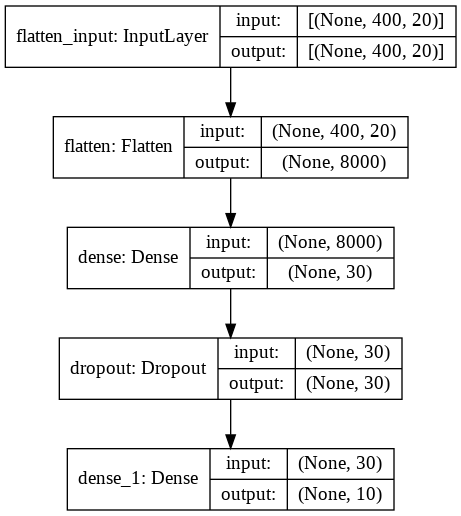

In [8]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=lr),
              metrics=['accuracy'])

print(model.summary())
plot_model(model, "model.png", show_shapes=True)

### Train


In [9]:
y_train = to_categorical(y_train, n_class)
y_val = to_categorical(y_val, n_class)

# Number of epochs
num_epochs = 80

# Calculate also the prediction and network loss for the validation set:
history = model.fit(X_train, y_train, epochs=80, batch_size=batch_size, validation_data=(X_val, y_val), shuffle=True)

Epoch 1/80
19/19 [==============================] - 4s 28ms/step - loss: 2.1296 - accuracy: 0.2424 - val_loss: 1.7409 - val_accuracy: 0.4756
Epoch 2/80
19/19 [==============================] - 0s 7ms/step - loss: 1.6387 - accuracy: 0.4584 - val_loss: 1.4059 - val_accuracy: 0.6189
Epoch 3/80
19/19 [==============================] - 0s 7ms/step - loss: 1.2519 - accuracy: 0.6246 - val_loss: 1.1810 - val_accuracy: 0.6677
Epoch 4/80
19/19 [==============================] - 0s 8ms/step - loss: 0.9548 - accuracy: 0.7202 - val_loss: 1.0310 - val_accuracy: 0.7150
Epoch 5/80
19/19 [==============================] - 0s 8ms/step - loss: 0.7649 - accuracy: 0.7602 - val_loss: 0.9650 - val_accuracy: 0.7228
Epoch 6/80
19/19 [==============================] - 0s 7ms/step - loss: 0.6414 - accuracy: 0.8106 - val_loss: 0.8925 - val_accuracy: 0.7370
Epoch 7/80
19/19 [==============================] - 0s 7ms/step - loss: 0.5303 - accuracy: 0.8399 - val_loss: 0.8542 - val_accuracy: 0.7370
Epoch 8/80
19/19 [=

### Model loss and accuracy

Plots of loss and accuracy for training and validation set at each epoch.



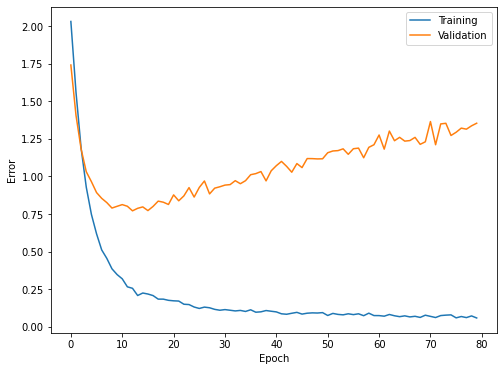

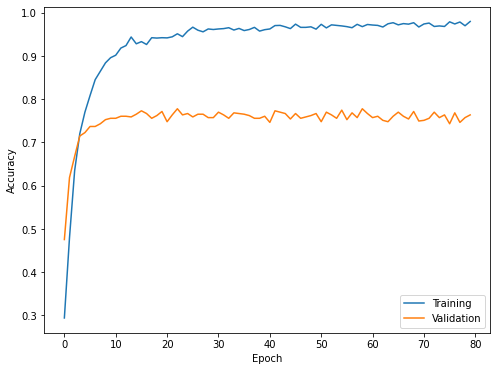

{'loss': [2.030639886856079, 1.5595992803573608, 1.186165690422058, 0.9282060265541077, 0.7472990155220032, 0.6180508732795715, 0.5111056566238403, 0.4545799195766449, 0.3853778541088104, 0.3470051884651184, 0.3188122808933258, 0.26555636525154114, 0.25565028190612793, 0.20777876675128937, 0.22431203722953796, 0.21766385436058044, 0.20731480419635773, 0.18372087180614471, 0.18356595933437347, 0.17573748528957367, 0.1724512279033661, 0.1708594113588333, 0.14972920715808868, 0.1475614607334137, 0.1311812698841095, 0.12166865915060043, 0.13058938086032867, 0.12622535228729248, 0.11560823023319244, 0.10979563742876053, 0.11401508003473282, 0.10973212867975235, 0.10519534349441528, 0.1085534542798996, 0.10171153396368027, 0.11274794489145279, 0.09668593853712082, 0.09920710325241089, 0.10779786109924316, 0.10310351848602295, 0.09869592636823654, 0.08606365323066711, 0.08305114507675171, 0.08960793912410736, 0.0956314206123352, 0.08413730561733246, 0.09003397077322006, 0.09229229390621185, 0

In [10]:
x_axis = range(num_epochs)
plt.figure(figsize=(8, 6))
# loss_training:
plt.plot(x_axis, history.history['loss'])
# loss_validation
plt.plot(x_axis, history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend(('Training', 'Validation'))
plt.show()

plt.figure(figsize=(8, 6))
# accuracy training
plt.plot(x_axis, history.history['accuracy'])
# accuracy validation
plt.plot(x_axis, history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(('Training', 'Validation'))
plt.show()

print(history.history)

### Confusion matrix
The confusion matrix shows how well is predicted each class and which are the most common mis-classifications.

Code based on http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


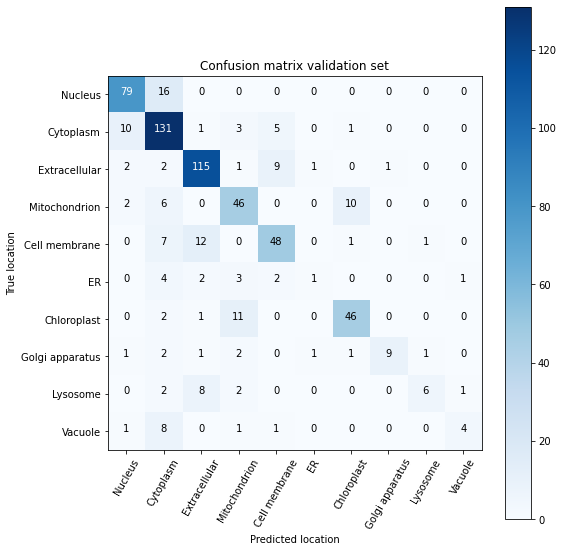

In [13]:
Y_pred = model.predict(X_val)
y_pred = np.argmax(Y_pred, axis=1)

confusion_mat = confusion_matrix(validation['y_val'], y_pred)

plt.figure(figsize=(8, 8))
colormap = plt.cm.Blues
plt.imshow(confusion_mat, interpolation='nearest', cmap=colormap)
plt.title('Confusion matrix validation set')
plt.colorbar()
tick_marks = np.arange(n_class)
classes = ['Nucleus', 'Cytoplasm', 'Extracellular', 'Mitochondrion', 'Cell membrane', 'ER', 'Chloroplast',
                'Golgi apparatus', 'Lysosome', 'Vacuole']

plt.xticks(tick_marks, classes, rotation=60)
plt.yticks(tick_marks, classes)

thresh = confusion_mat.max() / 2.
for i, j in itertools.product(range(confusion_mat.shape[0]), range(confusion_mat.shape[1])):
    plt.text(j, i, confusion_mat[i, j],
             horizontalalignment="center",
             color="white" if confusion_mat[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True location')
plt.xlabel('Predicted location')
plt.show()